In [ ]:
import os
from PIL import Image
import tensorflow as tf
import cv2 as cv
from tensorflow import keras
from matplotlib import image
from matplotlib import pyplot as plt
import torch 
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torchvision
from torchvision import transforms
from glob import glob
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
type0_list = glob('/content/drive/My Drive/type_2021/PP/*.jpg')
type1_list = glob('/content/drive/My Drive/type_2021/PET/*.jpg')
type2_list = glob('/content/drive/My Drive/type_2021/PS/*.jpg')
type3_list = glob('/content/drive/My Drive/type_2021/HDPE/*.jpg')
type4_list = glob('/content/drive/My Drive/type_2021/LDPE/*.jpg')

In [ ]:
balance = min(len(type0_list),len(type1_list),len(type2_list),len(type3_list),len(type4_list))

In [ ]:
index_0 = []
index_1 = []
index_2 = []
index_3 = []
index_4 = []
# index_5 = []
for i in range((balance)):
  # if i not in index_0
  index_0.append(type0_list[random.randint(0,len(type0_list)-1)])
  index_1.append(type1_list[random.randint(0,len(type1_list)-1)])
  index_2.append(type2_list[random.randint(0,len(type2_list)-1)])
  index_3.append(type3_list[random.randint(0,len(type3_list)-1)])
  index_4.append(type4_list[random.randint(0,len(type4_list)-1)])
  # index_5.append(type5_list[random.randint(0,len(type5_list)-1)])

In [ ]:
def img_to_np(fpaths,label,m,n,resize=True):  
    img_array = []
    lab_array = []
    for fname in fpaths:
      try:
        # print(fname)
        img = Image.open(fname).convert('RGB')
        if(resize): img = img.resize((m, n))
        img_array.append(np.asarray(img))
        lab_array.append(label)
      except:
        continue
    images = np.array(img_array)
    labels = np.array(lab_array)
    return images, labels

In [ ]:
img_type0,lab_type0 = img_to_np(index_0,0,224,224)
img_type0 = img_type0.astype(np.float32)/ 255.

img_type1,lab_type1 = img_to_np(index_1,1,224,224)
img_type1 = img_type1.astype(np.float32)/ 255.

img_type2,lab_type2 = img_to_np(index_2,2,224,224)
img_type2 = img_type2.astype(np.float32)/ 255.

img_type3,lab_type3 = img_to_np(index_3,3,224,224)
img_type3 = img_type3.astype(np.float32)/ 255.

img_type4,lab_type4 = img_to_np(index_4,4,224,224)
img_type4 = img_type4.astype(np.float32)/ 255.


In [ ]:
class_names=['PP','PET','PS','HDPE','LDPE']
# class_names=['bottle','can','plastic','trasnparanet plastic','vinyl','steel']
num_class = len(class_names)

In [ ]:
'''
m=224
n=224
trans = transforms.Compose([transforms.Resize((m,n)),transforms.ToTensor()])
trainset = torchvision.datasets.ImageFolder(root="/content/drive/My Drive/Plastic IMAGE",transform=trans)
'''

'\nm=224\nn=224\ntrans = transforms.Compose([transforms.Resize((m,n)),transforms.ToTensor()])\ntrainset = torchvision.datasets.ImageFolder(root="/content/drive/My Drive/Plastic IMAGE",transform=trans)\n'

In [ ]:
'''
trainloader = DataLoader(trainset,batch_size=len(trainset))
# trainloader = DataLoader(trainset,batch_size=5)
'''

'\ntrainloader = DataLoader(trainset,batch_size=len(trainset))\n# trainloader = DataLoader(trainset,batch_size=5)\n'

In [ ]:
'''
dataiter= iter(trainloader)
images,labels = dataiter.next()
'''

'\ndataiter= iter(trainloader)\nimages,labels = dataiter.next()\n'

In [ ]:
'''
IMG=images
img= np.zeros((len(IMG),m,n,3))
for i in range(len(IMG)):
  img[i]=np.asarray(IMG[i].T)
'''

'\nIMG=images\nimg= np.zeros((len(IMG),m,n,3))\nfor i in range(len(IMG)):\n  img[i]=np.asarray(IMG[i].T)\n'

In [ ]:
def noisy(noise_typ,image):
   if noise_typ == "gauss":
      row,col,ch= image.shape
      mean = 0
      var = 0.1
      sigma = var**0.5
      gauss = np.random.normal(mean,sigma,(row,col,ch))
      gauss = gauss.reshape(row,col,ch)
      noisy = image + gauss
      return noisy
      
   elif noise_typ == "s":
      row,col,ch = image.shape
      s_vs_p = 0.5
      amount = 0.004
      out = np.copy(image)
      # Salt mode
      num_salt = np.ceil(amount * image.size * s_vs_p)
      coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
      out[coords] = 1
      return out

   elif noise_typ =="p":
      row,col,ch = image.shape
      s_vs_p = 0.5
      amount = 0.004
      out = np.copy(image)
      # Pepper mode
      num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
      coords = [np.random.randint(0, i - 1, int(num_pepper))for i in image.shape]
      out[coords] = 0
      return out

   elif noise_typ == "poisson":
      vals = len(np.unique(image))
      vals = 2 ** np.ceil(np.log2(vals))
      noisy = np.random.poisson(image * vals)
      return noisy

   elif noise_typ =="speckle":
      row,col,ch = image.shape
      gauss = np.random.randn(row,col,ch)
      gauss = gauss.reshape(row,col,ch)        
      noisy = image + image * gauss
      return noisy

In [ ]:
def make_image_array(IMG,label):
  imagess=[]
  image_label=[]
  #IMG=np.asarray(IMG)
  for i in range(len(IMG)):
    img=IMG[i]
    flipped = tf.image.flip_left_right(img)
    rotated90 = tf.image.rot90(img)
    rotated180 = tf.image.rot90(rotated90)
    rotated270 = tf.image.rot90(rotated180)
    gauss = noisy('gauss',img)
    s = noisy('s',img)
    p = noisy('p',img)
    # poisson = noisy('poisson',img)
    speckel = noisy('speckle',img)
    cropped = tf.image.central_crop(img, central_fraction=0.85)
    cropped1 = tf.image.central_crop(img, central_fraction=0.9)
    cropped2 = tf.image.central_crop(img, central_fraction=0.95)
    #grayscaled = tf.image.rgb_to_grayscale(img)
    saturated = tf.image.adjust_saturation(img, 3)
    saturated1 = tf.image.adjust_saturation(img, 2)
    bright = tf.image.adjust_brightness(img, 0.4)
    bright1 = tf.image.adjust_brightness(img, 0.6)
    bright2 = tf.image.adjust_brightness(img, 0.8)
    
    # img=cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    # flipped=cv.cvtColor(np.float32(flipped),cv.COLOR_BGR2GRAY)
    # rotated90 = cv.cvtColor(np.float32(rotated90),cv.COLOR_BGR2GRAY)
    # rotated180 = cv.cvtColor(np.float32(rotated180),cv.COLOR_BGR2GRAY)
    # rotated270 = cv.cvtColor(np.float32(rotated270),cv.COLOR_BGR2GRAY)
    # cropped = cv.cvtColor(np.float32(cropped),cv.COLOR_BGR2GRAY)
    # cropped1 = cv.cvtColor(np.float32(cropped1),cv.COLOR_BGR2GRAY)
    # cropped2 = cv.cvtColor(np.float32(cropped2),cv.COLOR_BGR2GRAY)    
    
    # gauss=cv.resize(np.float32(gauss),(m,n), interpolation=cv.INTER_AREA)
    # # sp=cv.resize(np.float32(sp),(m,n), interpolation=cv.INTER_AREA)
    # speckel=cv.resize(np.float32(speckel),(m,n), interpolation=cv.INTER_AREA)
    m = 224
    n = 224
    cropped=cv.resize(np.float32(cropped),(m,n), interpolation=cv.INTER_AREA)
    cropped1=cv.resize(np.float32(cropped1),(m,n), interpolation=cv.INTER_AREA)
    cropped2=cv.resize(np.float32(cropped2),(m,n), interpolation=cv.INTER_AREA)

    imagess.append(np.float32(img))
    imagess.append(np.float32(flipped))
    imagess.append(np.float32(rotated90))
    imagess.append(np.float32(rotated180))
    imagess.append(np.float32(rotated270))
    imagess.append(np.float32(gauss))
    imagess.append(np.float32(s))
    imagess.append(np.float32(p))
    # imagess.append(poisson)
    imagess.append(np.float32(speckel))
    imagess.append(np.float32(cropped))
    imagess.append(np.float32(cropped1))
    imagess.append(np.float32(cropped2))
    #images.append(grayscaled)
    imagess.append(np.float32(saturated))
    imagess.append(np.float32(saturated1))
    imagess.append(np.float32(bright))
    imagess.append(np.float32(bright1))
    imagess.append(np.float32(bright2))
    
    l = label[i]
    for j in range(17):
      image_label.append(l)
  return np.asarray(imagess), np.asarray(image_label)

In [ ]:
'''
class_names=['pet','Yo','Ya','sam','cont','lead','deter']
num_class = len(class_names)

pe1=0
pe2=0
pe3=0
pp1=0
pp2=0
#pp3=0
ps1=0
ps2=0

for i in range(len(labels)):
  if labels[i]==0:
    pe1+=1
  if labels[i]==3:
    pe2+=1
  if labels[i]==6:
    pe3+=1
  if labels[i]==1:
    pp1+=1
  if labels[i]==4:
    pp2+=1
 # if labels[i]==5:
 #   pp3+=1
  if labels[i]==2:
    ps1+=1
  if labels[i]==5:
    ps2+=1
'''

"\nclass_names=['pet','Yo','Ya','sam','cont','lead','deter']\nnum_class = len(class_names)\n\npe1=0\npe2=0\npe3=0\npp1=0\npp2=0\n#pp3=0\nps1=0\nps2=0\n\nfor i in range(len(labels)):\n  if labels[i]==0:\n    pe1+=1\n  if labels[i]==3:\n    pe2+=1\n  if labels[i]==6:\n    pe3+=1\n  if labels[i]==1:\n    pp1+=1\n  if labels[i]==4:\n    pp2+=1\n # if labels[i]==5:\n #   pp3+=1\n  if labels[i]==2:\n    ps1+=1\n  if labels[i]==5:\n    ps2+=1\n"

In [ ]:
#print(pe1,pe2,pe3,pp1,pp2,ps1,ps2)

In [ ]:
'''
ind_pe1=[]
ind_pe2=[]
ind_pe3=[]
ind_pp1=[]
ind_pp2=[]
ind_ps1=[]
ind_ps2=[]

min1 = min(pe1,pe2,pe3,pp1,pp2,ps1,ps2)

while len(ind_pe1)<min1:
  num = random.randint(0,pe1-1)
  ind_pe1.append(num)

while len(ind_pe2)<min1:
  num = random.randint(0,pe2-1)
  ind_pe2.append(num)

while len(ind_pe3)<min1:
  num = random.randint(0,pe3-1)
  ind_pe3.append(num)

while len(ind_pp1)<min1:
  num = random.randint(0,pp1-1)
  ind_pp1.append(num)

while len(ind_pp2)<min1:
  num = random.randint(0,pp2-1)
  ind_pp2.append(num)

while len(ind_ps1)<min1:
  num = random.randint(0,ps1-1)
  ind_ps1.append(num)

while len(ind_ps2)<min1:
  num = random.randint(0,ps2-1)
  ind_ps2.append(num)

'''

'\nind_pe1=[]\nind_pe2=[]\nind_pe3=[]\nind_pp1=[]\nind_pp2=[]\nind_ps1=[]\nind_ps2=[]\n\nmin1 = min(pe1,pe2,pe3,pp1,pp2,ps1,ps2)\n\nwhile len(ind_pe1)<min1:\n  num = random.randint(0,pe1-1)\n  ind_pe1.append(num)\n\nwhile len(ind_pe2)<min1:\n  num = random.randint(0,pe2-1)\n  ind_pe2.append(num)\n\nwhile len(ind_pe3)<min1:\n  num = random.randint(0,pe3-1)\n  ind_pe3.append(num)\n\nwhile len(ind_pp1)<min1:\n  num = random.randint(0,pp1-1)\n  ind_pp1.append(num)\n\nwhile len(ind_pp2)<min1:\n  num = random.randint(0,pp2-1)\n  ind_pp2.append(num)\n\nwhile len(ind_ps1)<min1:\n  num = random.randint(0,ps1-1)\n  ind_ps1.append(num)\n\nwhile len(ind_ps2)<min1:\n  num = random.randint(0,ps2-1)\n  ind_ps2.append(num)\n\n'

In [ ]:
'''
l1=pe1
l2=l1+pp1
l3=l2+ps1

l4=l3+pe2
l5=l4+pp2
l6=l5+ps2

l7=l6+pe3

PE__1=img[0:l1]
PP__1=img[l1:l2]
PS__1=img[l2:l3]

PE__2=img[l3:l4]
PP__2=img[l4:l5]
PS__2=img[l5:l6]

PE__3=img[l6:l7]

PE1_label=labels[0:l1]
PP1_label=labels[l1:l2]
PS1_label=labels[l2:l3]

PE2_label=labels[l3:l4]
PP2_label=labels[l4:l5]
PS2_label=labels[l5:l6]

PE3_label=labels[l6:l7]

PE__1=PE__1[ind_pe1]
PP__1=PP__1[ind_pp1]
PS__1=PS__1[ind_ps1]

PE__2=PE__2[ind_pe2]
PP__2=PP__2[ind_pp2]
PS__2=PS__2[ind_ps2]

PE__3=PE__3[ind_pe3]

PE1_label = PE1_label[ind_pe1]
PP1_label = PP1_label[ind_pp1]
PS1_label = PS1_label[ind_ps1]

PE2_label = PE2_label[ind_pe2]
PP2_label = PP2_label[ind_pp2]
PS2_label = PS2_label[ind_ps2]

PE3_label = PE3_label[ind_pe3]
'''

'\nl1=pe1\nl2=l1+pp1\nl3=l2+ps1\n\nl4=l3+pe2\nl5=l4+pp2\nl6=l5+ps2\n\nl7=l6+pe3\n\nPE__1=img[0:l1]\nPP__1=img[l1:l2]\nPS__1=img[l2:l3]\n\nPE__2=img[l3:l4]\nPP__2=img[l4:l5]\nPS__2=img[l5:l6]\n\nPE__3=img[l6:l7]\n\nPE1_label=labels[0:l1]\nPP1_label=labels[l1:l2]\nPS1_label=labels[l2:l3]\n\nPE2_label=labels[l3:l4]\nPP2_label=labels[l4:l5]\nPS2_label=labels[l5:l6]\n\nPE3_label=labels[l6:l7]\n\nPE__1=PE__1[ind_pe1]\nPP__1=PP__1[ind_pp1]\nPS__1=PS__1[ind_ps1]\n\nPE__2=PE__2[ind_pe2]\nPP__2=PP__2[ind_pp2]\nPS__2=PS__2[ind_ps2]\n\nPE__3=PE__3[ind_pe3]\n\nPE1_label = PE1_label[ind_pe1]\nPP1_label = PP1_label[ind_pp1]\nPS1_label = PS1_label[ind_ps1]\n\nPE2_label = PE2_label[ind_pe2]\nPP2_label = PP2_label[ind_pp2]\nPS2_label = PS2_label[ind_ps2]\n\nPE3_label = PE3_label[ind_pe3]\n'

In [ ]:
def l_s(initial_learning_rate,step):
  lr = tf.keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate,
      decay_steps=5,
      decay_rate=0.99,
      staircase=True)
  return lr

In [ ]:
def Top_K_accuracy_for_k_fold(model,Test_images,Test_labels,j,history):
  top1 = 0.0
  top2 = 0.0
  top3 = 0.0
  # top4 = 0.0
  # top5 = 0.0    
  class_probs = model.predict(Test_images)
  for i, l in enumerate(Test_labels):
      class_prob = class_probs[i]
      
      top_values1 = (-class_prob).argsort()[:1]
      top_values2 = (-class_prob).argsort()[:2]
      top_values3 = (-class_prob).argsort()[:3]
      # top_values4 = (-class_prob).argsort()[:4]
      # top_values5 = (-class_prob).argsort()[:5]
      
      if np.isin(np.array([l]), top_values1):
          top1 += 1.0
      if np.isin(np.array([l]), top_values2):
          top2 += 1.0    
      if np.isin(np.array([l]), top_values3):
          top3 += 1.0
      # if np.isin(np.array([l]), top_values4):
      #     top4 += 1.0    
      # if np.isin(np.array([l]), top_values5):
      #     top5 += 1.0

  TT1=round((1-top1/len(Test_labels))*100,1)
  TT2=round((1-top2/len(Test_labels))*100,1)
  TT3=round((1-top3/len(Test_labels))*100,1)
  # TT4=round((1-top4/len(Test_labels))*100,1)
  # TT5=round((1-top5/len(Test_labels))*100,1)

  return TT1,TT2,TT3

In [ ]:
def Signal_for_k_fold(predictions,Test_labels):
  Volume_label=[]
  for i in range(len(predictions)):
    if np.argmax(predictions[i])%3==0:
      Volume_label.append(0)
    if np.argmax(predictions[i])%3==1:
      Volume_label.append(1)
    if np.argmax(predictions[i])%3==2:
      Volume_label.append(2)
    
      
  True_label=[]
  for i in range(len(predictions)):
    if (Test_labels[i])%3==0:
      True_label.append(0)
    if (Test_labels[i])%3==1:
      True_label.append(1)
    if (Test_labels[i])%3==2:
      True_label.append(2)
    
  count =0
  for i in range(len(predictions)):
    if Volume_label[i] == True_label[i]:
      count+=1

  return 100-((count/len(predictions))*100)

In [ ]:
def Top_K_accuracy(model,Test_images,Test_labels,j,history):
  top1 = 0.0
  top2 = 0.0
  top3 = 0.0
  top4 = 0.0
  top5 = 0.0    
  class_probs = model.predict(Test_images)
  for i, l in enumerate(Test_labels):
      class_prob = class_probs[i]
      
      top_values1 = (-class_prob).argsort()[:1]
      top_values2 = (-class_prob).argsort()[:2]
      top_values3 = (-class_prob).argsort()[:3]
      top_values4 = (-class_prob).argsort()[:4]
      top_values5 = (-class_prob).argsort()[:5]
      
      if np.isin(np.array([l]), top_values1):
          top1 += 1.0
      if np.isin(np.array([l]), top_values2):
          top2 += 1.0    
      if np.isin(np.array([l]), top_values3):
          top3 += 1.0
      if np.isin(np.array([l]), top_values4):
          top4 += 1.0    
      if np.isin(np.array([l]), top_values5):
          top5 += 1.0

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('{} model accuracy'.format(j),color='w')
  plt.ylabel('accuracy',color='w')
  plt.xlabel('epoch',color='w')
  plt.legend(['train', 'valid'], loc='upper left')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('{} model loss'.format(j),color='w')
  plt.ylabel('loss',color='w')
  plt.xlabel('epoch',color='w')
  plt.legend(['train', 'valid'], loc='upper left')
  plt.show()
  
  # print(j)
  # print("top1 error", round((1-top1/len(Test_labels))*100,1),'%')
  # print("top2 error", round((1-top2/len(Test_labels))*100,1),'%')
  # print("top3 error", round((1-top3/len(Test_labels))*100,1),'%')
  # print("top4 error", round((1-top4/len(Test_labels))*100,1),'%')
  # print("top5 error", round((1-top5/len(Test_labels))*100,1),'%')
  print('\n')  

In [ ]:
def SHOW_ME(model,Test_images,Test_labels):
  predictions = model.predict(Test_images)  
  A,B = Signal(predictions,Test_labels)
  num_rows = 6
  num_cols = 1
  num_images = num_rows*num_cols
  idx = np.random.randint(0,len(Test_labels),size=num_images)
  plt.figure(figsize=(15, 20))

  for i in range(num_images):
    plt.subplot(num_rows, 3*num_cols, 3*i+1)
    plot_image(idx[i], predictions, Test_labels, Test_images)

    if np.argmax(predictions[idx[i]])%3 ==0:
      plt.subplot(num_rows, 3*num_cols, 3*i+2)
      plt.grid(False)
      plt.xticks([])
      plt.yticks([])
      plt.title('Prediction')
      img = cv.imread("PE1.png")
      plt.imshow(img[:,:,::-1])

    if np.argmax(predictions[idx[i]])%3 ==1:
      plt.subplot(num_rows, 3*num_cols, 3*i+2)
      plt.grid(False)
      plt.xticks([])
      plt.yticks([])
      plt.title('Prediction')
      img = cv.imread("PP1.png")
      plt.imshow(img[:,:,::-1])


    if np.argmax(predictions[idx[i]])%3 ==2:
      plt.subplot(num_rows, 3*num_cols, 3*i+2)
      plt.grid(False)
      plt.xticks([])
      plt.yticks([])
      plt.title('Prediction')
      img = cv.imread("PS1.png")
      plt.imshow(img[:,:,::-1])

    plt.subplot(num_rows, 3*num_cols, 3*i+3)
    plot_value_array(idx[i], predictions, Test_labels)
  plt.show()

In [ ]:
def determine(true_label):
  LAST_label=int(true_label)%5
  if LAST_label==0:
    LAST_label='PP'
  if LAST_label==1:
    LAST_label='PET'
  if LAST_label==2:
    LAST_label='PS'
  if LAST_label==3:
    LAST_label='HDPE' 
  if LAST_label==4:
    LAST_label='LDPE'
 
  return LAST_label

def C(t,p):
  if determine(t) == determine(p):
    c='k'
  else:
    c='red'
  return c

def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  
  img = cv.flip(img,1)
  rotated90 = tf.image.rot90(img)

  teeee = np.float32(rotated90)
  Rectangle = cv.rectangle(teeee,(7,7),(217,217),(0,255,0),3)
  plt.imshow(Rectangle[:,:,::-1])
  

  predicted_label = np.argmax(predictions_array)
  

  if predicted_label==true_label:
    color = 'k'
  else:
    color = 'red' 
  
  A=predictions_array[0]+predictions_array[3]+predictions_array[6]
  B=predictions_array[1]+predictions_array[4]
  C=predictions_array[2]+predictions_array[5]

  if np.argmax(predictions_array)%3 ==0:
    acc = A
  if np.argmax(predictions_array)%3 ==1:
    acc = B
  if np.argmax(predictions_array)%3 ==2:
    acc = C  
  # plt.title("P : {} {:2.0f}% ( T : {})".format(class_names[predicted_label],
  #                               100*acc,
  #                               class_names[int(true_label)]),color=color, fontsize=9)
  plt.title('Real Image')
def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  D=[]
  A=predictions_array[0]+predictions_array[3]+predictions_array[6]
  B=predictions_array[1]+predictions_array[4]
  C=predictions_array[2]+predictions_array[5]
  D.append(A)
  D.append(B)
  D.append(C)
  # thisplot = plt.bar(range(3), D,tick_label=['PE','PP','PS'])
  
  thisplot = plt.bar(range(num_class),predictions_array,tick_label=['PP','PET','PS','HDPE','LDPE'])
  # thisplot.label.set_color('w')
  # plt.xlabel(color = 'w')
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)
  

  if predicted_label==true_label:
    plt.title("Real & Prediction is : {}  ".format(class_names[true_label]),
                                      color='k', fontsize=12)
  else:
   plt.title("Predictions is : {} but  Real : {}  ".format(class_names[predicted_label],class_names[true_label]),
                                      color='k', fontsize=12)

  
  thisplot[predicted_label].set_color('red')
  thisplot[int(true_label)].set_color('blue')

In [ ]:
def Results(model,history,Test_images,Test_labels,model_name):
  Top_K_accuracy(model,Test_images,Test_labels,model_name,history)
  SHOW_ME(model,Test_images,Test_labels)

In [ ]:
def Signal(predictions,Test_labels):
  Volume_label=[]
  for i in range(len(predictions)):
    if np.argmax(predictions[i])%3==0:
      Volume_label.append(0)
    if np.argmax(predictions[i])%3==1:
      Volume_label.append(1)
    if np.argmax(predictions[i])%3==2:
      Volume_label.append(2)
    
      
  True_label=[]
  for i in range(len(predictions)):
    if (Test_labels[i])%3==0:
      True_label.append(0)
    if (Test_labels[i])%3==1:
      True_label.append(1)
    if (Test_labels[i])%3==2:
      True_label.append(2)
    
  count =0
  for i in range(len(predictions)):
    if Volume_label[i] == True_label[i]:
      count+=1


  # print('정확도 : {:2.0f}%'.format((count/len(predictions))*100))  
  return Volume_label,True_label

In [ ]:
from sklearn.utils import shuffle
Meta_image = np.concatenate((img_type0, img_type1, img_type2, img_type3, img_type4), axis=0)
Meta_label = np.concatenate((lab_type0, lab_type1, lab_type2, lab_type3, lab_type4), axis=0)
#Meta_image = np.concatenate((PE__1,PE__2,PE__3,PP__1,PP__2,PS__1,PS__2),axis=0)
#Meta_label = np.concatenate((PE1_label,PE2_label,PE3_label,PP1_label,PP2_label,PS1_label,PS2_label),axis=0)
Meta_image, Meta_label = shuffle(Meta_image, Meta_label)

In [ ]:
model = tf.keras.Sequential([
tf.keras.applications.MobileNetV2(weights='imagenet',input_shape=(224,224,3),pooling=None,classes=1000),
# tf.keras.layers.Dense(7,activation='softmax',activity_regularizer = tf.keras.regularizers.l1(0.5))
tf.keras.layers.Dense(num_class,activation='softmax',activity_regularizer = tf.keras.regularizers.l1(0.5))
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 1000)              3538984   
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 5005      
Total params: 3,543,989
Trainable params: 3,509,877
Non-trainable params: 34,112
_________________________________________________________________


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 1000)              3538984   
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 5005      
Total params: 3,543,989
Trainable params: 3,509,877
Non-trainable params: 34,112
_________________________________________________________________


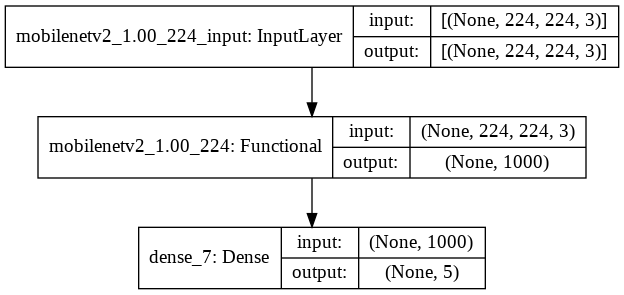

In [ ]:
model.summary()
tf.keras.utils.plot_model(model, show_shapes = True)

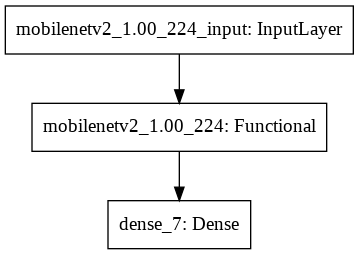

In [ ]:
# model.summary()
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96
)

In [ ]:
t_img,t_lab = make_image_array(Meta_image,Meta_label)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


In [ ]:
L=1e-5*3
S=200
Opt = tf.keras.optimizers.Adam(learning_rate=l_s(L,20))
Loss= tf.keras.losses.SparseCategoricalCrossentropy()

# Define the model architecture
model1 = tf.keras.Sequential([
tf.keras.applications.MobileNetV2(weights='imagenet',input_shape=(224,224,3),pooling=None,classes=1000),
tf.keras.layers.Dense(500,activation='relu'),
 tf.keras.layers.Dense(50,activation='relu'),
 #tf.keras.layers.Dense(30,activation='relu'),
tf.keras.layers.Dense(num_class,activation='softmax',activity_regularizer = tf.keras.regularizers.l1(0.5))
# tf.keras.layers.Dense(num_class,activation='softmax')
])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=10)
model1.compile(optimizer=Opt,loss=Loss,metrics=['accuracy'])

# checkpoint_path = "/content/drive/My Drive/Plastic_classification_weight"
# checkpoint_path = checkpoint_path+str(6)+"/cp.ckpt"
# model1.save_weights(checkpoint_path)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 1000)              3538984   
_________________________________________________________________
dense_8 (Dense)              (None, 500)               500500    
_________________________________________________________________
dense_9 (Dense)              (None, 50)                25050     
_________________________________________________________________
dense_10 (Dense)             (None, 5)                 255       
Total params: 4,064,789
Trainable params: 4,030,677
Non-trainable params: 34,112
_________________________________________________________________


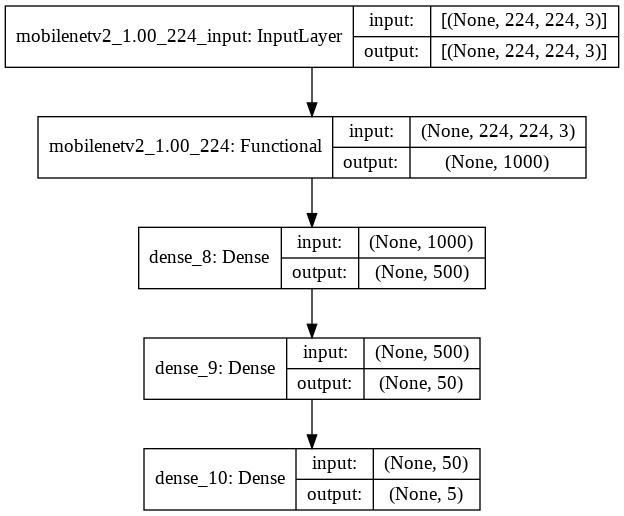

In [ ]:
model1.summary()
tf.keras.utils.plot_model(model1, show_shapes = True)

In [ ]:
# history1 = model1.fit(t_img, t_lab,batch_size=32,epochs=S,callbacks=[callback],verbose=1)
history1 = model1.fit(t_img, t_lab,batch_size=64,epochs=1,verbose=1,validation_data =(t_img,t_lab))

48/48 [==============================] - 22s 385ms/step - loss: 2.0960 - accuracy: 0.5624 - val_loss: 2.0838 - val_accuracy: 0.5846


In [ ]:
model1.save('/content/drive/My Drive/동영상플라찍기/model_pla.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
checkpoint_path = "/content/drive/My Drive/Plastic_classification_weight_500_100_30/cp.ckpt"
# checkpoint_path = checkpoint_path+str(0000)+"/cp.ckpt"
model1.save_weights(checkpoint_path)  

In [ ]:
from numpy.random import seed
seed(1)
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
Meta_image, Meta_label = shuffle(Meta_image, Meta_label)


num_folds = 5
# Define per-fold score containers


# Define the K-fold Cross Validator
# inputs = np.concatenate((Train_images1, Test_images1, Valid_images1), axis=0)
# targets = np.concatenate((Train_labels, Test_labels, Valid_labels), axis=0)

index_test = []
# Define per-fold score containers

kfold = KFold(n_splits=num_folds, shuffle=True)
# K-fold Cross Validation model evaluation

fold_no = 1
d121_t1=[]
d121_t2=[]
d121_t3=[]
sss=[]
d121_acc_per_fold = []
d121_loss_per_fold = [] 
  # Model configuration
batch =64
# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation

fold_no = 1

for train, test in kfold.split(Meta_image, Meta_label):

  train_img, train_lab = make_image_array(Meta_image[train],Meta_label[train])
  train_img, train_lab = shuffle(train_img, train_lab)
  val_img,val_lab = Meta_image[test][0:int(len(test)/2)],Meta_label[test][0:int(len(test)/2)]
  test_img, test_lab = Meta_image[test][int(len(test)/2):],Meta_label[test][int(len(test)/2):]
  
  # print(val_img.shape,val_lab.shape)
  # print(test_img.shape,test_lab.shape)
  
  # index_test.append(test)
  # Model configuration
  S=30
  
  L=1e-5*3
  Opt = tf.keras.optimizers.Adam(learning_rate=l_s(L,S))
  Loss= tf.keras.losses.SparseCategoricalCrossentropy()
  # V = [test]int(len(test)/2)
  

  # Define the model architecture
  model1 = tf.keras.Sequential([
  tf.keras.applications.MobileNetV2(weights='imagenet',input_shape=(224,224,3),pooling=None,classes=1000),
  tf.keras.layers.Dense(500,activation='relu'),
  tf.keras.layers.Dense(50,activation='relu'),
  #tf.keras.layers.Dense(30,activation='relu'),
  tf.keras.layers.Dense(num_class,activation='softmax',activity_regularizer = tf.keras.regularizers.l1(0.04))
  # tf.keras.layers.Dense(num_class,activation='softmax')
  ])
  callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=10)
  model1.compile(optimizer=Opt,loss=Loss,metrics=['accuracy'])
  '''
  # Define the model architecture
  model1 = tf.keras.Sequential([
  tf.keras.applications.MobileNetV2(weights='imagenet',input_shape=(224,224,3),pooling=None,classes=1000),
  tf.keras.layers.Dense(num_class,activation='softmax',activity_regularizer = tf.keras.regularizers.l1(0.04))
  # tf.keras.layers.Dense(num_class,activation='softmax')
  ])
  callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
  model1.compile(optimizer=Opt,loss=Loss,metrics=['accuracy'])
  '''  
  #
  model1.summary()
  tf.keras.utils.plot_model(model1, show_shapes = True)
  #

  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training Mobile Net V2 for fold {fold_no} ...')
  
  # batch_size = int(len(img)/100)
  history1 = model1.fit(train_img, train_lab,batch_size=batch,epochs=S,callbacks=[callback],verbose=1,validation_data=(val_img,val_lab))
  checkpoint_path = "/content/drive/My Drive/Plastic_classification_weight"
  checkpoint_path = checkpoint_path+str(fold_no)+"/cp.ckpt"
  model1.save_weights(checkpoint_path)  
  model1_path = '/content/drive/My Drive/Plastic_classification_pb/'+str(fold_no)
  model1.save(model1_path)
  
  top1,top2,top3=Top_K_accuracy_for_k_fold(model1,test_img, test_lab,3,history1)

  # Generate generalization metrics
  a,b=model1.evaluate(test_img,test_lab)
  # print(f'Training for fold Dense121{fold_no} ...')
  print(f'Mobile Net V2 Evaluate Score for fold {fold_no}: [{model1.metrics_names[0]} of {round(a,3)}], [{model1.metrics_names[1]} of {round(b,3)*100}%]')
  d121_acc_per_fold.append(b)
  d121_loss_per_fold.append(a)
  d121_t1.append(top1)
  d121_t2.append(top2)
  d121_t3.append(top3)
  sss.append(Signal_for_k_fold(model1.predict(test_img),test_lab))
  # Increase fold number
  fold_no = fold_no + 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 1000)              3538984   
_________________________________________________________________
dense_29 (Dense)             (None, 500)               500500    
_________________________________________________________________
dense_30 (Dense)             (None, 50)                25050     
_________________________________________________________________
dense_31 (Dense)             (None, 5)                 255       
Total params: 4,064,789
Trainable params: 4,030,677
Non-trainable params: 34,112
_________________________________________________________________
------------------------------------------------------------------------
Training Mobile Net V2 for fold 1 ...
Epoch 1/30
39/39 [==============================] - 16s 322ms/step - loss: 1.6364 - accuracy: 0.4024 - val_loss: 1.6304 - val

INFO:tensorflow:Assets written to: /content/drive/My Drive/Plastic_classification_pb/1/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Plastic_classification_pb/1/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


1/1 [==============================] - 0s 33ms/step - loss: 1.1758 - accuracy: 0.8889
Mobile Net V2 Evaluate Score for fold 1: [loss of 1.176], [accuracy of 88.9%]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 1000)              3538984   
_________________________________________________________________
dense_32 (Dense)             (None, 500)               500500    
_________________________________________________________________
dense_33 (Dense)             (None, 50)                25050     
_________________________________________________________________
dense_34 (Dense)             (None, 5)                 255       
Total params: 4,064,789
Trainable params: 4,030,677
Non-trainable params: 34,112
_________________________________________________________________
------------------------------------------------------------------------
Training Mobile Net V2 for fold 2 ...
Epoch 1/30
39/39 [==============================] - 16s 320ms/step - loss: 1.6407 - accuracy: 0.5270 - val_loss: 1.6298 - val

INFO:tensorflow:Assets written to: /content/drive/My Drive/Plastic_classification_pb/2/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Plastic_classification_pb/2/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


1/1 [==============================] - 0s 33ms/step - loss: 1.1625 - accuracy: 0.8333
Mobile Net V2 Evaluate Score for fold 2: [loss of 1.162], [accuracy of 83.3%]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 1000)              3538984   
_________________________________________________________________
dense_35 (Dense)             (None, 500)               500500    
_________________________________________________________________
dense_36 (Dense)             (None, 50)                25050     
_________________________________________________________________
dense_37 (Dense)             (None, 5)                 255       
Total params: 4,064,789
Trainable params: 4,030,677
Non-trainable params: 34,112
_________________________________________________________________
------------------------------------------------------------------------
Training Mobile Net V2 for fold 3 ...
Epoch 1/30
39/39 [==============================] - 16s 319ms/step - loss: 1.6442 - accuracy: 0.4293 - val_loss: 1.6338 - val

INFO:tensorflow:Assets written to: /content/drive/My Drive/Plastic_classification_pb/3/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Plastic_classification_pb/3/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


1/1 [==============================] - 0s 34ms/step - loss: 1.0620 - accuracy: 1.0000
Mobile Net V2 Evaluate Score for fold 3: [loss of 1.062], [accuracy of 100.0%]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 1000)              3538984   
_________________________________________________________________
dense_38 (Dense)             (None, 500)               500500    
_________________________________________________________________
dense_39 (Dense)             (None, 50)                25050     
_________________________________________________________________
dense_40 (Dense)             (None, 5)                 255       
Total params: 4,064,789
Trainable params: 4,030,677
Non-trainable params: 34,112
_________________________________________________________________
------------------------------------------------------------------------
Training Mobile Net V2 for fold 4 ...
Epoch 1/30
39/39 [==============================] - 16s 319ms/step - loss: 1.6406 - accuracy: 0.5253 - val_loss: 1.6242 - val

INFO:tensorflow:Assets written to: /content/drive/My Drive/Plastic_classification_pb/4/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Plastic_classification_pb/4/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


1/1 [==============================] - 0s 33ms/step - loss: 1.0943 - accuracy: 0.8889
Mobile Net V2 Evaluate Score for fold 4: [loss of 1.094], [accuracy of 88.9%]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 1000)              3538984   
_________________________________________________________________
dense_41 (Dense)             (None, 500)               500500    
_________________________________________________________________
dense_42 (Dense)             (None, 50)                25050     
_________________________________________________________________
dense_43 (Dense)             (None, 5)                 255       
Total params: 4,064,789
Trainable params: 4,030,677
Non-trainable params: 34,112
_________________________________________________________________
------------------------------------------------------------------------
Training Mobile Net V2 for fold 5 ...
Epoch 1/30
39/39 [==============================] - 16s 317ms/step - loss: 1.6423 - accuracy: 0.4085 - val_loss: 1.6433 - val

INFO:tensorflow:Assets written to: /content/drive/My Drive/Plastic_classification_pb/5/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Plastic_classification_pb/5/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


1/1 [==============================] - 0s 33ms/step - loss: 1.0844 - accuracy: 1.0000
Mobile Net V2 Evaluate Score for fold 5: [loss of 1.084], [accuracy of 100.0%]


In [ ]:
# == Provide average scores ==
print('--------------Mobile Net V2--------------')
print('각 fold 당 성능')
for i in range(0, len(d121_acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> 폴드 {i+1}의 - Loss: {round(d121_loss_per_fold[i],3)} - Accuracy: {round(d121_acc_per_fold[i],3)}%')
print('------------------------------------------------------------------------')
print('모든 폴드들의 평균 성능:')
print(f'> Accuracy: {round(np.mean(d121_acc_per_fold),3)} (+- {round(np.std(d121_acc_per_fold),2)})')
print(f'> Loss: {round(np.mean(d121_loss_per_fold),2)}')
print(f'> class error : {round(np.mean(sss),2)}%')
print(f'> top 1 error : {round(np.mean(d121_t1),2)}%')
print(f'> top 2 error : {round(np.mean(d121_t2),2)}%')
print(f'> top 3 error : {round(np.mean(d121_t3),2)}%')

--------------Mobile Net V2--------------
각 fold 당 성능
------------------------------------------------------------------------
> 폴드 1의 - Loss: 1.176 - Accuracy: 0.889%
------------------------------------------------------------------------
> 폴드 2의 - Loss: 1.162 - Accuracy: 0.833%
------------------------------------------------------------------------
> 폴드 3의 - Loss: 1.062 - Accuracy: 1.0%
------------------------------------------------------------------------
> 폴드 4의 - Loss: 1.094 - Accuracy: 0.889%
------------------------------------------------------------------------
> 폴드 5의 - Loss: 1.084 - Accuracy: 1.0%
------------------------------------------------------------------------
모든 폴드들의 평균 성능:
> Accuracy: 0.922 (+- 0.07)
> Loss: 1.12
> class error : 6.67%
> top 1 error : 7.78%
> top 2 error : 3.34%
> top 3 error : 1.12%


In [ ]:
class_names=['PP','PET','PS','HDPE','LDPE']
num_class = len(class_names)

model1 = tf.keras.Sequential([
tf.keras.applications.MobileNetV2(weights='imagenet',input_shape=(224,224,3),pooling=None,classes=1000), tf.keras.layers.Dense(500,activation='relu'), tf.keras.layers.Dense(50,activation='relu'), tf.keras.layers.Dense(num_class,activation='softmax',activity_regularizer = tf.keras.regularizers.l1(0.04))
])
#import pre-trained weight
checkpoint_path ="/content/drive/My Drive/Plastic_classification_weight1/cp.ckpt"
model1.load_weights(checkpoint_path)

from PIL import Image
fpaths = '/content/drive/MyDrive/type_2021/PET/2021_05_21_17_43_45_PS_PS.jpg'
m = 224
n = 224
label = 'PET'
img_array = []
lab_array = []

# print(fname)  
img = Image.open(fpaths).convert('RGB')
print(img.size)
img = img.resize((m, n))
print(img.size)
img_array.append(np.asarray(img))
#print(img_array.shape)
lab_array.append(label)

images = np.array(img_array)
labels = np.array(lab_array)

images = images.astype(np.float32) /255.



#predict
preds = model.predict(images)
print(preds)
print(np.argmax(preds))
print(class_names[np.argmax(preds)],np.max(preds))